In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import MatplotlibSettings
import ROOT

Welcome to JupyROOT 6.26/10


In [4]:
modelfolder=['NLO-inc-dijet','NNLO-inc-dijet']

In [5]:
Q2=6
f1 = ROOT.TFile(modelfolder[0]+"/out.root","READ")
f2 = ROOT.TFile(modelfolder[1]+"/out.root","READ")
#f2.ls()
address= "SaveDPDFTGraph/Q2_"+str(Q2)+"__xpom_0.0030;1"
maral1=f1.Get(address)
maral2=f2.Get(address)
#maral2.ls()
maral12=maral1.Get("DPDF_ErrorsSymm;1/")
maral22=maral2.Get("DPDF_ErrorsSymm;1/")
NLO_sigma=maral12.Get("SIGMA;1")
NLO_gluon=maral12.Get("gluon;1")
NNLO_sigma=maral22.Get("SIGMA;1")
NNLO_gluon=maral22.Get("gluon;1")

In [6]:
## taken from:https://higgshunter.wordpress.com/2013/04/18/error-band-graph-in-pyroot/
## Edited by : HH :)
## some deprecated methods changed, added return
import ctypes ## HH: this is needed for ctypes variable type, ROOT.Double is obsolete!
def DrawErrorBand(graph):
    isErrorBand = graph.GetErrorYhigh(0) != -1 and graph.GetErrorYlow(0) != -1
    npoints     = graph.GetN()

    if not isErrorBand:
        graph.Draw("l")
        return

    # Declare individual TGraph objects used in drawing error band
    central, min, max = ROOT.TGraph(), ROOT.TGraph(), ROOT.TGraph()
    shapes = []
    for i in range((npoints-1)*4):
        shapes.append(ROOT.TGraph())

    # Set ownership of TGraph objects
    ROOT.SetOwnership(central, False)
    ROOT.SetOwnership(    min, False)
    ROOT.SetOwnership(    max, False)
    for shape in shapes:
        ROOT.SetOwnership(shape, False)

    # Get data points from TGraphAsymmErrors
    x, y, ymin, ymax = [], [], [], []
    xs, ys=[],[] ### HH
    for i in range(npoints):
        tmpX, tmpY =ctypes.c_double(0.), ctypes.c_double(0.) ## HH: using "ROOT.Double" will raise error
        graph.GetPoint(i, tmpX, tmpY)
        x.append(tmpX)
        y.append(tmpY)
        ymin.append(tmpY.value - graph.GetErrorYlow(i)) ## HH
        ymax.append(tmpY.value + graph.GetErrorYhigh(i)) ## HH
        #xs.append(tmpX.value) ## HH
        #ys.append(tmpY.value) ## HH
    xs = np.array([item.value for item in x]) ## HH
    ys = np.array([item.value for item in y]) ## HH
    ymins = np.array(ymin) ## HH
    ymaxs = np.array(ymax) ## HH
    # Fill central, min and max graphs
    for i in range(npoints):
        central.SetPoint(i, x[i], y[i])
        min.SetPoint(i, x[i], ymin[i])
        max.SetPoint(i, x[i], ymax[i])

    # Fill shapes which will be shaded to create the error band
    for i in range(npoints-1):
        for version in range(4):
            shapes[i+(npoints-1)*version].SetPoint((version+0)%4, x[i],   ymax[i])
            shapes[i+(npoints-1)*version].SetPoint((version+1)%4, x[i+1], ymax[i+1])
            shapes[i+(npoints-1)*version].SetPoint((version+2)%4, x[i+1], ymin[i+1])
            shapes[i+(npoints-1)*version].SetPoint((version+3)%4, x[i],   ymin[i])

    # Set attributes to those of input graph
    central.SetLineColor(graph.GetLineColor())
    central.SetLineStyle(graph.GetLineStyle())
    central.SetLineWidth(graph.GetLineWidth())
    min.SetLineColor(graph.GetLineColor())
    min.SetLineStyle(graph.GetLineStyle())
    max.SetLineColor(graph.GetLineColor())
    max.SetLineStyle(graph.GetLineStyle())
    for shape in shapes:
        shape.SetFillColor(graph.GetFillColor())
        shape.SetFillStyle(graph.GetFillStyle())

    # Draw
    for shape in shapes:
        shape.Draw("f")
    min.Draw("l")
    max.Draw("l")
    central.Draw("l")
    ROOT.gPad.RedrawAxis()
    res=[xs,ys,ymins,ymaxs] ## HH
    return res #HH

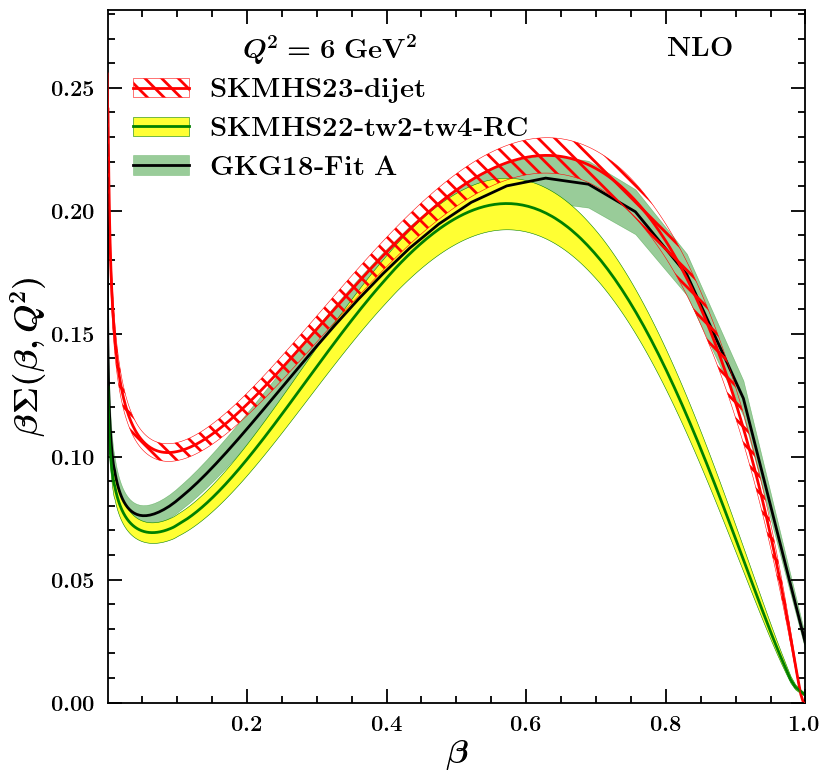

In [9]:
ulf   = pd.read_csv('./comparision-other-group/S_ulf.txt', sep='\t', header=None)
vadim = pd.read_csv('./comparision-other-group/S_vadim.txt', sep='\t', header=None)
###### Singlet
###################################################################################################################################
xv=vadim[0].to_numpy()
yv=vadim[1].to_numpy()
ymin=(vadim[1].to_numpy()-vadim[2].to_numpy())
ymax=(vadim[1].to_numpy()+vadim[2].to_numpy())

f, ax1 = plt.subplots(1, 1, sharex = "all",figsize=(9, 9))
plt.subplots_adjust(wspace = 0, hspace = 0)
############################################
color= 'k'
markerth=''
hatch='\\\\'
plt.rcParams['hatch.linewidth'] = 2.0  # previous pdf hatch linewidth
thlinestyle,linewidth='-',2.0
center_v=ax1.plot(xv, yv, color = color, lw = linewidth, marker=markerth)
alpha=0.4
bandcolor='g'
edgecolor='g'
#ax1.axhline(0, color='black', lw=linewidth, linestyle='dotted')
errband=ax1.fill_between(xv, np.array(ymax), np.array(ymin), color = bandcolor, alpha = alpha,edgecolor=edgecolor)
p_v = ax1.fill(np.NaN, np.NaN, color = bandcolor, alpha = alpha,edgecolor=edgecolor)# color=bandcolor, alpha=alpha)#### for combined legend only
###################################################################################################################################
xv,yv,ymin,ymax =DrawErrorBand(NNLO_sigma)
yv=yv*0.003
ymin=ymin*0.003
ymax=ymax*0.003
yv_NLO=yv
#################################################
plt.subplots_adjust(wspace = 0, hspace = 0)
ax1.set_title(r"\textbf{NLO}", x=0.85, y=1.0, pad=-33, fontsize = 20)
ax1.set_ylabel(r"\textbf{$\beta \Sigma (\beta,Q^2)$}")
ax1.set_xlabel(r"\textbf{$\beta$}")
ax1.set_ylim([0.,np.amax(ymax)*1.1])
ax1.set_xlim([1e-3, 1e0])
###################################################################################################################################
color= 'r'
markerth=''
hatch='\\\\'
plt.rcParams['hatch.linewidth'] = 2.0  # previous pdf hatch linewidth
thlinestyle,linewidth='-',2.0
center_NLO=ax1.plot(xv, yv, color = color, lw = linewidth, marker=markerth)
alpha=1
bandcolor="none"
edgecolor='r'
#ax1.axhline(0, color='black', lw=linewidth, linestyle='dotted')
errband=ax1.fill_between(xv, np.array(ymax), np.array(ymin), color = bandcolor, alpha = alpha,hatch=hatch ,edgecolor=edgecolor,zorder=10)
p_NLO = ax1.fill(np.NaN, np.NaN, color = bandcolor, alpha = alpha,edgecolor=edgecolor,hatch=hatch)#### for combined legend only
###################################################################################################################################
xv=ulf[0].to_numpy()
yv=ulf[1].to_numpy()
ymin=(ulf[1].to_numpy()-ulf[2].to_numpy())
ymax=(ulf[1].to_numpy()+ulf[2].to_numpy())
############################################
color= 'g'
markerth=''
thlinestyle,linewidth='-',2.0
center_u=ax1.plot(xv, yv, color = color, lw = linewidth, marker=markerth)
alpha=1
bandcolor='#ffff33'
edgecolor='g'
#ax1.axhline(0, color='black', lw=linewidth, linestyle='dotted')
errband=ax1.fill_between(xv, np.array(ymax), np.array(ymin), color = bandcolor, alpha = alpha,edgecolor=edgecolor)
p_u = ax1.fill(np.NaN, np.NaN, color = bandcolor, alpha = alpha,edgecolor=edgecolor)# color=bandcolor, alpha=alpha)#### for combined legend only

###################################################################################################################################
plt.rcParams['legend.title_fontsize'] = 'small'
ax1.legend([(p_NLO[0], center_NLO[0]),(p_u[0],center_u[0]),(p_v[0],center_v[0]) ],\
           [r'\textbf{SKMHS23-dijet}',r"\textbf{SKMHS22-tw2-tw4-RC}",r"\textbf{GKG18-Fit A}"],\
           loc='upper left', title= r"$Q^2 =$ "+ r"$\textbf{" + str(Q2) + "}$" +r" $ \textbf{GeV}^2$",fontsize=20)
#plt.show()
plt.savefig( "./Distribution-Plot/" +'comparison'+'_'+'sigma-'+str(Q2) + ".pdf")
plt.show()
plt.close()

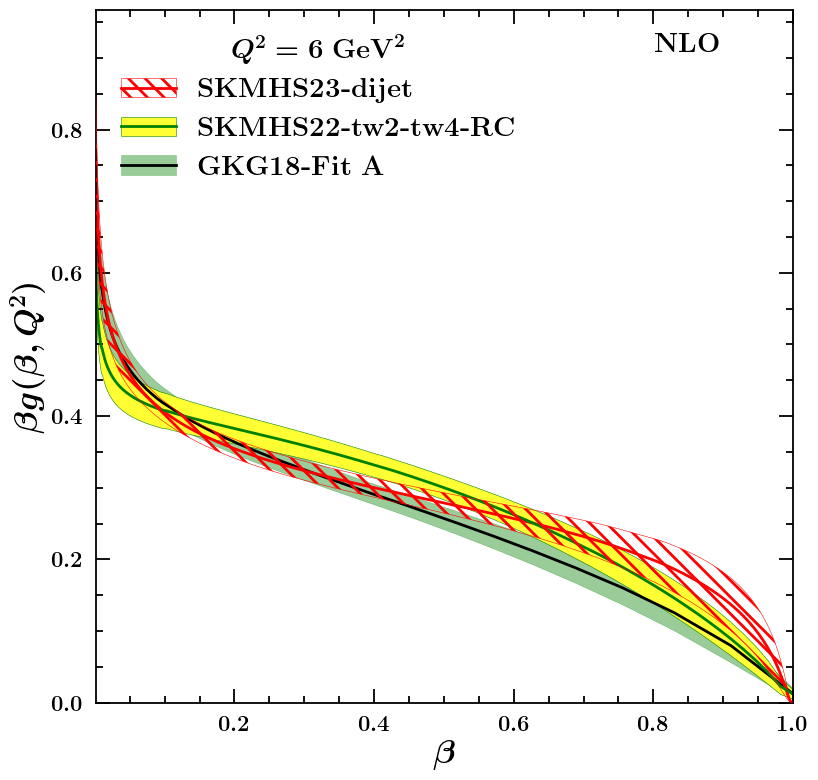

In [8]:
ulf   = pd.read_csv('./comparision-other-group/g_ulf.txt', sep='\t', header=None)
vadim = pd.read_csv('./comparision-other-group/g_vadim.txt', sep='\t', header=None)
f, ax1 = plt.subplots(1, 1, sharex = "all",figsize=(9, 9))
plt.subplots_adjust(wspace = 0, hspace = 0)
###### Gluon
xv=vadim[0].to_numpy()
yv=vadim[1].to_numpy()
ymin=(vadim[1].to_numpy()-vadim[2].to_numpy())
ymax=(vadim[1].to_numpy()+vadim[2].to_numpy())
############################################
color= 'k'
markerth=''
hatch='\\\\'
plt.rcParams['hatch.linewidth'] = 2.0  # previous pdf hatch linewidth
thlinestyle,linewidth='-',2.0
center_v=ax1.plot(xv, yv, color = color, lw = linewidth, marker=markerth)
alpha=0.4
bandcolor='g'
edgecolor='g'
#ax1.axhline(0, color='black', lw=linewidth, linestyle='dotted')
errband=ax1.fill_between(xv, np.array(ymax), np.array(ymin), color = bandcolor, alpha = alpha,edgecolor=edgecolor)
p_v = ax1.fill(np.NaN, np.NaN, color = bandcolor, alpha = alpha,edgecolor=edgecolor)# color=bandcolor, alpha=alpha)#### for combined legend only
###################################################################################################################################

xv,yv,ymin,ymax =DrawErrorBand(NLO_gluon)
yv=yv*0.003
ymin=ymin*0.003
ymax=ymax*0.003
yv_NLO=yv
#################################################
ax1.set_title(r"\textbf{NLO}", x=0.85, y=1.0, pad=-30, fontsize = 20)
ax1.set_ylabel(r"\textbf{$\beta g (\beta,Q^2)$}")
ax1.set_xlabel(r"\textbf{$\beta$}")
ax1.set_ylim([0.,np.amax(ymax)*1.1])
ax1.set_xlim([1e-3, 1e0])
###################################################################################################################################
color= 'r'
markerth=''
hatch='\\\\'
plt.rcParams['hatch.linewidth'] = 2.0  # previous pdf hatch linewidth
thlinestyle,linewidth='-',2.0
center_NLO=ax1.plot(xv, yv, color = color, lw = linewidth, marker=markerth)
alpha=1
bandcolor="none"
edgecolor='r'
#ax1.axhline(0, color='black', lw=linewidth, linestyle='dotted')
errband=ax1.fill_between(xv, np.array(ymax), np.array(ymin), color = bandcolor, alpha = alpha,hatch=hatch ,edgecolor=edgecolor,zorder=10)
p_NLO = ax1.fill(np.NaN, np.NaN, color = bandcolor, alpha = alpha,edgecolor=edgecolor,hatch=hatch)#### for combined legend only
###################################################################################################################################
xv=ulf[0].to_numpy()
yv=ulf[1].to_numpy()
ymin=(ulf[1].to_numpy()-ulf[2].to_numpy())
ymax=(ulf[1].to_numpy()+ulf[2].to_numpy())
############################################
color= 'g'
markerth=''
thlinestyle,linewidth='-',2.0
center_u=ax1.plot(xv, yv, color = color, lw = linewidth, marker=markerth)
alpha=1
bandcolor='#ffff33'
edgecolor='g'
#ax1.axhline(0, color='black', lw=linewidth, linestyle='dotted')
errband=ax1.fill_between(xv, np.array(ymax), np.array(ymin), color = bandcolor, alpha = alpha,edgecolor=edgecolor)
p_u = ax1.fill(np.NaN, np.NaN, color = bandcolor, alpha = alpha,edgecolor=edgecolor)# color=bandcolor, alpha=alpha)#### for combined legend only
###################################################################################################################################
ax1.legend([(p_NLO[0], center_NLO[0]),(p_u[0],center_u[0]),(p_v[0],center_v[0]) ],\
           [r'\textbf{SKMHS23-dijet}',r"\textbf{SKMHS22-tw2-tw4-RC}",r"\textbf{GKG18-Fit A}"],\
           loc='upper left',title=r"$Q^2 =$ "+ r"$\textbf{" + str(Q2) + "}$" +r" $ \textbf{GeV}^2$",fontsize=20)
plt.savefig( "./Distribution-Plot/" +'comparison'+'_'+'gluon-'+str(Q2) + ".pdf")
plt.show()
plt.close()